### 1. Import data and dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [2]:
penguins = pd.read_csv("https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/master/datasets/penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

### 2. Model data and creating plotting functions

Split the data into two subsets to investigate how trees will predict values based on an out-of-samples dataset.

In [3]:
data, target = penguins[culmen_columns], penguins[target_column]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)
range_features = {
    feature_name: (data[feature_name].min() - 1, data[feature_name].max() + 1)
    for feature_name in data.columns}

A linear classifier will define a linear separation to split classes using a linear combination of the input
features. In a 2-dimensional space, it means that a linear classifier will
define some oblique lines that best separate our classes. We define a
function below that, given a set of data points and a classifier, will plot
the decision boundaries learnt by the classifier.

In [4]:
def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")

    return ax

### 3. Obtain decision boundaries for linear classifier

In [5]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
linear_model.fit(data_train, target_train)

LogisticRegression()

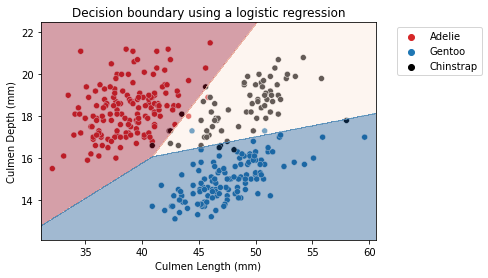

In [6]:
# create a palette to be used in the scatterplot
palette = ["tab:red", "tab:blue", "black"]

ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                     hue=target_column, palette=palette)
plot_decision_function(linear_model, range_features, ax=ax)
# put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a logistic regression")

We see that the lines are a combination of the input features since they are
not perpendicular a specific axis. Indeed, this is due to the model
parametrization that we saw in the previous notebook, controlled by the
model's weights and intercept.

Besides, it seems that the linear model would be a good candidate for
such problem as it gives good accuracy.

In [7]:
linear_model.fit(data_train, target_train)
test_score = linear_model.score(data_test, target_test)
print(f"Accuracy of the LogisticRegression: {test_score:.2f}")

Accuracy of the LogisticRegression: 0.98


Unlike linear models, decision trees are non-parametric models: they are not
controlled by a mathematical decision function and do not have weights or
intercept to be optimized.

Indeed, decision trees will partition the space by considering a single
feature at a time. Let's illustrate this behaviour by having a decision
tree make a single split to partition the feature space.

### 4. Fit a Decision Tree Classifier

In [8]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=1)

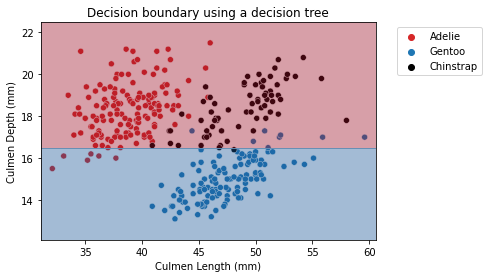

In [9]:
ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                     hue=target_column, palette=palette)
plot_decision_function(tree, range_features, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a decision tree")

The partitions found by the algorithm separates the data along the axis
"Culmen Depth", discarding the feature "Culmen Length". Thus, it highlights
that a decision tree does not use a combination of feature when making a
split. We can look more in depth at the tree structure.

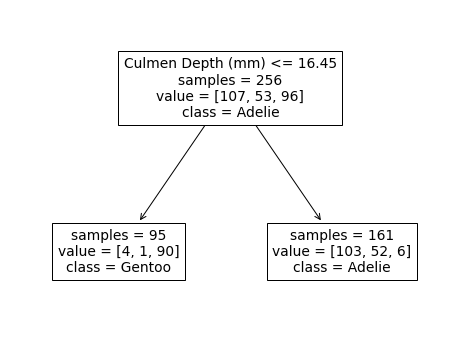

In [11]:
_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=culmen_columns,
              class_names=tree.classes_, impurity=False, ax=ax)

We see that the split was done the culmen depth feature. The original
dataset was subdivided into 2 sets based on the culmen depth
(inferior or superior to 16.45 mm).

This partition of the dataset minimizes the class diversities in each
sub-partitions. This measure is also known as a **criterion**,
and is a settable parameter.

If we look more closely at the partition, we see that the sample superior to
16.45 belongs mainly to the Adelie class. Looking at the values, we indeed
observe 103 Adelie individuals in this space. We also count 52 Chinstrap
samples and 6 Gentoo samples. We can make similar interpretation for the
partition defined by a threshold inferior to 16.45mm. In this case, the most
represented class is the Gentoo species.

Let's see how our tree would work as a predictor. Let's start to see the
class predicted when the culmen depth is inferior to the threshold.

In [12]:
tree.predict([[0, 15]])

array(['Gentoo'], dtype=object)

The class predicted is the Gentoo. We can now check if we pass a culmen
depth superior to the threshold.

In [14]:
tree.predict([[0, 17]])

array(['Adelie'], dtype=object)

In this case, the tree predicts the Adelie specie.

Thus, we can conclude that a decision tree classifier will predict the most
represented class within a partition.

During the training, we have a count of samples in each partition, we can
also compute the probability of belonging to a specific class within this
partition.

In [15]:
y_pred_proba = tree.predict_proba([[0, 17]])
y_proba_class_0 = pd.Series(y_pred_proba[0], index=tree.classes_)

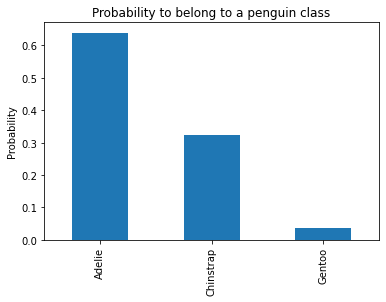

In [16]:
y_proba_class_0.plot.bar()
plt.ylabel("Probability")
_ = plt.title("Probability to belong to a penguin class")

We will manually compute the different probability directly from the tree
structure.

In [17]:
adelie_proba = 103 / 161
chinstrap_proba = 52 / 161
gentoo_proba = 6 / 161
print(f"Probabilities for the different classes:\n"
      f"Adelie: {adelie_proba:.3f}\n"
      f"Chinstrap: {chinstrap_proba:.3f}\n"
      f"Gentoo: {gentoo_proba:.3f}\n")

Probabilities for the different classes:
Adelie: 0.640
Chinstrap: 0.323
Gentoo: 0.037



In [18]:
tree.predict_proba([[10000, 17]])

array([[0.63975155, 0.32298137, 0.03726708]])

Going back to our classification problem, the split found with a maximum
depth of 1 is not powerful enough to separate the three species and the model
accuracy is low when compared to the linear model.

In [19]:
tree.fit(data_train, target_train)
test_score = tree.score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.78


Indeed, it is not a surprise. We saw earlier that a single feature will not be able to separate all three species. However, from the previous analysis we saw that by using both features we should be able to get fairly good results.

In the next exercise, you will increase the size of the tree depth. You will get intuitions on how the space partitioning is repeated over time.